In [1]:
import cbayes.sample
import cbayes.distributions
import cbayes.solve
import numpy as np
import ipywidgets as wd
import matplotlib.pyplot as plt
import scipy.stats as sstats
import scipy.spatial as spat

The following linear map $Q_s: \mathbb{R}^2 \to \mathbb{R}^2$ is defined to have skewness $s$ at all $\lambda \in \Lambda$.  

$$
Q_s(\lambda) = \lbrace \, \lambda_1, \; \lambda_1 \sqrt{s^2 - 1} + \lambda_2 \, \rbrace
$$

### Useful Identities
Let $\lambda$ denote an arbitrary Gaussian random variable with mean $\mu_\lambda$ and covariance $\Sigma_\lambda$,
$$
\lambda \sim N\left(\mu_\lambda, \Sigma_\lambda\right).
$$
Then, for a matrix $A$, 
$$
A\lambda \sim N\left(A\mu_\lambda,\, A\Sigma_\lambda A^T\right)
$$
Let $\eta = A\lambda + e$, where $e\sim N(0,\Sigma_e)$,   
then the posterior $p(\lambda | \eta)$ is given by

$$
p(\lambda | \eta=\bar{\eta}) = N\left(\hat{\mu}, \hat{\Sigma}\right),
$$
where 
$$
\hat{\mu} = \mu_\lambda + \Sigma_\lambda A^T\left(A\Sigma_\lambda A^T + \Sigma_e\right)^{-1}\left(\bar{\eta} - A\mu_\lambda\right)
$$
and
$$
\hat{\Sigma} = \Sigma_\lambda - \Sigma_\lambda A^T\left(A\Sigma_\lambda A^T + \Sigma_e\right)^{-1}A\Sigma_\lambda
$$

[These notes](https://cs.nyu.edu/~roweis/notes/gaussid.pdf) by Sam Roweis also provide some useful identities.


### Define a function that generates an arbitrarily ill-condidtioned 2-2 map


In [2]:
def make_model(skew, tile=1):
    # this function makes a linear map whos first component is the x-unit vector
    # and each subsequent component is a norm-1 vector satisfying the property
    # that the 2-2 map made from it and the aforementioned unit vector is a map
    # with skewness in skew_range, which is a list of desired skewnesses   
    # TODO currently this map only works for 2-D input space     
    
    def my_model(parameter_samples):
        Q_map = skewmat(skew, tile)
#         QoI_samples = Q_map@parameter_samples
        QoI_samples = np.dot(parameter_samples, np.transpose(Q_map))
#         QoI_samples = Q_map@parameter_samples.T
        return QoI_samples
    return my_model

def skewmat(skew, tile=1):
    Q_map = [ [1.0, 0.0] ] # all map components have the same norm, rect_size to have measures of events equal btwn spaces.
    Q_map.append( [np.sqrt(skew**2 - 1), 1] ) # taken with the first component, this leads to a 2-2 map with skewsness 's'
    Q_map = np.array( Q_map )
    Q_map = np.tile(Q_map.T, tile).T
    return Q_map

def gauss_sol(prior_mean, prior_std, data_std, A, data):
    if type(prior_mean) is int:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is float:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is list:
        prior_mean = np.array(prior_mean).reshape(-1,1)
    if type(prior_std) is list:
        prior_std = np.array(prior_std).reshape(-1,1)
    if type(data_std) is list:
        data_std = np.array(data_std).reshape(-1,1)
    prior_cov = prior_std*prior_std*np.eye(2) 
    data_cov = data_std*data_std*np.eye(len(data_std)) 
    
    ASA = A@prior_cov@A.T
    
    precision = np.linalg.inv(ASA + data_cov)
    kahlman_update = (prior_cov@A.T@precision)
    post_mean = prior_mean + kahlman_update@(data - A@prior_mean)
    post_cov = prior_cov - kahlman_update@A@prior_cov
    
    return prior_mean, prior_cov, post_mean, post_cov

Example of Analytical Solution

In [3]:
# A = skewmat(1.01)
# # print(A)
# data_std = 0.25
# prior_std = 1
# prior_mean = 0
# lam_true = np.array([0.0, 0.0])
# obs_data = A@lam_true.T + data_std*np.random.randn(2)

# prior_mean, prior_cov, post_mean, post_cov = gauss_sol(prior_mean, prior_std, data_std, A, obs_data.reshape(-1,1) )
# print(post_mean.T,'\n')
# print(post_cov)


### Generate samples and map them

In [39]:
def compare(num_samples=5000, skew=1, prior_x=0.0, prior_y=0.0, 
            prior_std = 1.0, data_std = 0.25, trials=1, 
            color_map = 'jet', num_levels = 40, seed=12, show_accept=False, avg_contours=False, show_plot=True):
    fsize=16 # font size
    vmin, vmax = 0, None # height bounds for filled contours
    pbound = 1.0 # parameter space bounds
    dbound = 1.0  # data space bound
    prior_alpha = 0.15 # transparency of prior contours
    true_posterior_alpha = 0.5 # transparency for the contours of the kahlman solution
    
    num_plot_pts = 50 # resoltion for 1-D plots
    show_kahlman = True
    show_slice = False # messy - show slice through middle of axis to interrogate posterior
    normalize_marginals = False # normalizing the marginals (dividing the )
    num_observations = trials*2
    
    if normalize_marginals:
        maxht = 0.15 # max y-axis height
        vline_ht = 0.05 # height of vertical bar
    else:
        maxht = 150
        vline_ht = 100 # shows truth
    
    model = make_model(skew, trials)
    lam_true = np.array([0.25, 0.25])
    obs_data = model(lam_true)
    
    
    np.random.seed(seed*2)
    obs_data_noisy = obs_data + data_std*np.random.randn(num_observations)
#     print('data:', obs_data_noisy)
    # ANALYTICAL SOLUTION
    prior_mean = np.array([prior_x, prior_y])
    A = skewmat(skew, trials)
    prior_mean, prior_cov, post_mean, post_cov = gauss_sol(prior_mean, 
                          prior_std, np.ones(num_observations)*data_std, A, obs_data_noisy)
    
    post_pred = model(post_mean)
    
    
    ########## DEFINE MSE ####################################################################################################
#     mse_fun = MSE_generator(model, obs_data_noisy, data_std)
    
    def mse_fun(input_samples, data = obs_data_noisy):
        output_samples = model(input_samples)
        if avg_contours:
            return (1./data_std)*(1./np.sqrt(len(data)))*np.sum( output_samples - data, axis=1)
        else:
            data = data.reshape(trials,2)
            data_0 = data[:,0]
            data_1 = data[:,1]
            os_1 = (1./data_std)*(1./np.sqrt(len(data_0)))*np.sum( output_samples[:,0::2] - data_0, axis=1).reshape(-1,1)
            os_2 = (1./data_std)*(1./np.sqrt(len(data_1)))*np.sum( output_samples[:,1::2] - data_1, axis=1).reshape(-1,1)
            output_samps = np.concatenate([os_1, os_2],axis=1)
            return output_samps
    ########################################################################################################################
    
    s_input_set = cbayes.sample.sample_set(size=(num_samples, 2))
    s_input_set.set_dist(dim=0, dist='normal', kwds={'loc': prior_mean[0], 'scale': prior_std})
    s_input_set.set_dist(dim=1, dist='normal', kwds={'loc': prior_mean[1], 'scale': prior_std})
#     input_samples = s_input_set.generate_samples(seed=seed)
    input_samples = sstats.distributions.norm.rvs(size=(num_samples,2))
    s_input_set.samples = input_samples
#     print('\n',s_input_set.samples[1:3,:])
    modelV = make_model(skew, 1)
    output_samples_vector_valued = modelV(input_samples)
    

    #### VECTOR PROBLEM
    s_output_set_vector_valued = cbayes.sample.sample_set(size=(num_samples, 2))
    s_output_set_vector_valued.samples = output_samples_vector_valued
    
    p_set_vector = cbayes.sample.problem_set(s_input_set, s_output_set_vector_valued)
    
    # Set observed 
    obs_data_reshape = obs_data_noisy.reshape(trials,2) # compute mean
    mean_data = np.mean(obs_data_reshape,axis=0)
    
    
    p_set_vector.set_observed_dist(dim=0, dist='normal', 
                                   kwds={'loc': mean_data[0], 'scale': data_std})
    p_set_vector.set_observed_dist(dim=1, dist='normal', 
                                   kwds={'loc': mean_data[1], 'scale': data_std})
    
    p_set_vector.model = make_model(skew, 1)
    
    p_set_vector.compute_pushforward_dist()
    p_set_vector.set_ratio()
    if show_plot:
        print("Working....")
        cbayes.solve.problem(p_set_vector)
        accepted_inputs_vector = p_set_vector.input.samples[p_set_vector.accept_inds,:]
        print('num accepted for vector-valued:', len(accepted_inputs_vector), 
              'mean: %2.4f, %2.4f'%(np.mean(accepted_inputs_vector[:,0]), np.mean(accepted_inputs_vector[:,1])), 
              'sd: %2.4f, %2.4f'%(np.std(accepted_inputs_vector[:,0]), np.std(accepted_inputs_vector[:,1])) )
        print('mean data:', mean_data)
        print('post cov:',post_cov)
    
    #### SCALAR PROBLEM
#             randtrials = 10
#     for _ in range(randtrials):
    #     mse_fun = cbayes.sample.MSE_generator(model, obs_data_noisy, data_std)
    
    output_samples_scalar_valued = mse_fun(input_samples) 
#     print('computed VS values. output_samples_scalar_valued has shape', output_samples_scalar_valued.shape)
    ########################################################################################################################
    
    if avg_contours:
        s_output_set_scalar_valued = cbayes.sample.sample_set(size=(num_samples, 1))
    else:
        s_output_set_scalar_valued = cbayes.sample.sample_set(size=(num_samples, 2))
    s_output_set_scalar_valued.samples = output_samples_scalar_valued
    
    p_set_scalar = cbayes.sample.problem_set(s_input_set, s_output_set_scalar_valued)
    
    
    # Set observed 
    # p_set_scalar.set_observed_dist('gamma', {'a':num_observations/2.0, 'scale':2.0/num_observations}, dim=0) # MSE functional
    p_set_scalar.set_observed_dist('norm', {'loc':0, 'scale':1.0}, dim=0) # AVG ERROR Functional
    p_set_scalar.model = mse_fun
    if not avg_contours:
        p_set_scalar.set_observed_dist('norm', {'loc':0, 'scale':1.0}, dim=1)
    
    
#     p_set_scalar.compute_pushforward_dist(method='sk', kwds={'bandwidth': 0.1}) ############################################################################
    p_set_scalar.compute_pushforward_dist()
    p_set_scalar.set_ratio()
    
    if show_plot:
        cbayes.solve.problem(p_set_scalar)
        accepted_inputs_scalar = p_set_scalar.input.samples[p_set_scalar.accept_inds,:]
        accepted_outputs_scalar = p_set_scalar.input.samples[p_set_scalar.accept_inds,:]
        print('num accepted for scalar-valued:', len(accepted_inputs_scalar), 
              'mean: %2.4f, %2.4f'%(np.mean(accepted_inputs_scalar[:,0]), np.mean(accepted_inputs_scalar[:,1])), 
              'sd: %2.4f, %2.4f'%(np.std(accepted_inputs_scalar[:,0]), np.std(accepted_inputs_scalar[:,1])) )
        print('\nmean of vector ratio:', np.mean(p_set_vector.ratio))
        print('mean of scalar ratio:', np.mean(p_set_scalar.ratio))
    vpost = p_set_vector.ratio*s_input_set.dist.pdf(input_samples)
    spost = p_set_scalar.ratio*s_input_set.dist.pdf(input_samples)
    # ERRORS 
    
    
    # Kahlman 
#     print('kahlman prediction', np.power(model(post_mean.reshape(1,-1))- obs_data_noisy,2) )
    
#     def post_pdf(input_samples):
#         return sstats.multivariate_normal.pdf(input_samples, mean=post_mean.ravel(), cov=post_cov, allow_singular=True)
    
    
    mud_idx_s = np.argmax(spost)
    mud_idx_v = np.argmax(vpost)
#     print('our prediction', np.power(model(input_samples[s_idx,:]) - obs_data_noisy,2) )
    mud_pred_error_s = np.mean(np.power(model(input_samples[mud_idx_s,:]) - obs_data_noisy,2))
    mud_pred_error_v = np.mean(np.power(model(input_samples[mud_idx_v,:])  - obs_data_noisy,2))
    error_ku = np.mean(np.power(model(post_mean.reshape(1,-1)) - obs_data_noisy,2))
    
    if show_plot:
        print('MSE_KU_pred: ', error_ku)
        print('MSE_IS_pred: ', mud_pred_error_s, '\nvector:', mud_pred_error_v)
    
    D = {'mud_pred_error_s': mud_pred_error_s,
        'mud_pred_error_v': mud_pred_error_v,
        'map_pred_error': error_ku}
    
    if show_plot: 
        ########## PLOTTING ################
    #     fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
        fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
        # handles if you want to reorient figures 
        vv_contours = axs[0,0] # fourth option 

        vs_contours = axs[0,2]
        vs_pf = axs[1,2]

        vv_post = axs[1,0]
        vs_post = axs[1,1]

        vs_post_marg = axs[0,1]   


        x = input_samples[:,0] 
        y = input_samples[:,1]
        xs = accepted_inputs_scalar[:,0]
        ys = accepted_inputs_scalar[:,1]

        xv = accepted_inputs_vector[:,0]
        yv = accepted_inputs_vector[:,1]


        # CONTOURS FOR FORWARD MAP
        vv_contours.tricontour(x, y, output_samples_vector_valued[:,0], num_levels, cmap=color_map,
                              vmin=vmin, vmax=vmax)
        vv_contours.tricontour(x, y, output_samples_vector_valued[:,1], num_levels, cmap=color_map,
                              vmin=vmin, vmax=vmax)
        if avg_contours:
            vs_contours.tricontour(x, y, output_samples_scalar_valued, num_levels, cmap=color_map,
                              vmin=vmin, vmax=vmax)
        else:
            vs_contours.tricontour(x, y, output_samples_scalar_valued[:,0], num_levels, cmap=color_map,
                              vmin=vmin, vmax=vmax)
            vs_contours.tricontour(x, y, output_samples_scalar_valued[:,1], num_levels, cmap=color_map,
                              vmin=vmin, vmax=vmax)

        vv_contours.set_title('Parameter Space with Contours\nof Vector-Valued QoI Map', fontsize=fsize)
        vs_contours.set_title('Parameter Space with Contours\nof Scalar-Valued QoI Map', fontsize=fsize)


        # MESH PLOT

        vv_post.tricontourf(x, y, vpost, int(num_levels/2), cmap=color_map,
                              vmin=vmin, vmax=vmax)
        vs_post.tricontourf(x, y, spost, int(num_levels/2), cmap=color_map,
                              vmin=vmin, vmax=vmax)

        # CONTOURS OF KAHLMAN POSTERIOR
        post_pdf = sstats.multivariate_normal.pdf(input_samples, mean=post_mean, cov=post_cov, allow_singular=True)
        prior_pdf = sstats.multivariate_normal.pdf(input_samples, mean=prior_mean, cov=prior_cov, allow_singular=True)

        ####  SHOW KAHLMAN GAIN SOL ####
        if show_kahlman:
            vv_post.tricontour(x, y, post_pdf, int(num_levels/2), cmap='Greys', 
                                vmin=vmin, vmax=vmax, alpha=true_posterior_alpha)
            vs_post.tricontour(x, y, post_pdf, int(num_levels/2), cmap='Greys', 
                            vmin=vmin, vmax=vmax, alpha=true_posterior_alpha)

        # PRIOR CONTOURS
        vv_contours.tricontour(x, y, prior_pdf, int(num_levels/2), cmap='Greys', 
                            vmin=vmin, vmax=vmax, alpha=prior_alpha)
        vs_contours.tricontour(x, y, prior_pdf, int(num_levels/2), cmap='Greys', 
                            vmin=vmin, vmax=vmax, alpha=prior_alpha)

        vv_post.set_title('Posterior Distribution for\nVector-Valued Approach', fontsize=fsize)
        vs_post.set_title('Posterior Distribution for\nScalar-Valued Approach', fontsize=fsize)





        vdist = np.linalg.norm(vpost-post_pdf,1)/num_samples
        sdist = np.linalg.norm(spost-post_pdf,1)/num_samples
        bdist = np.linalg.norm(spost-vpost,1)/num_samples
    #     print('L-1 error: %2.2e vector | %2.2e scalar | %2.2e each'%(vdist, sdist, bdist))

    
        # PLOT PUSH-FORWARD AND OBSERVED FOR SCALAR MAP

        xx = np.linspace(-5, 5, num_plot_pts)
        if avg_contours:
            vs_pf.plot(xx, p_set_scalar.pushforward_dist.pdf(xx), label='Push-forward of Prior')
            vs_pf.plot(xx, p_set_scalar.observed_dist.pdf(xx), label='Observed Density')
    #     else:
    #         vs_pf.plot(xx, p_set_scalar.pushforward_dist.pdf(xx), label='Push-forward of Prior')
    #         vs_pf.plot(xx, p_set_scalar.pushforward_dist.pdf(xx), label='Push-forward of Prior')
    #         vs_pf.plot(xx, p_set_scalar.observed_dist.pdf(xx), label='Observed Density')
        pf_acc = cbayes.distributions.gkde(accepted_outputs_scalar.reshape(-1,1))
        vs_pf.plot(xx, pf_acc.pdf(xx.reshape(-1,1)), label='kde pf of updated')
        vs_pf.plot(xx, sstats.norm.pdf(xx,loc=accepted_outputs_scalar.mean(), scale=accepted_outputs_scalar.std()), label='fit pf of updated')
        vs_pf.legend()
    #     vs_pf.set_title('Data Space for\n$q = [(q_1-o_1)^2 + (q_2-o_2)^2]/2\sigma_e^2$', fontsize=fsize)
        vs_pf.set_title('Data Space for QoI with %0004d trials'%trials)

        # PLOT DATA FOR VECTORS
    #     xx = np.linspace(-dbound, dbound, num_plot_pts)
    #     vv_data_1.plot(xx, sstats.distributions.norm.pdf(xx,loc=mean_data[0],scale=data_std), 
    #                   color='blue', ls='-', label='$q_1$')
    #     vv_data_2.plot(xx, sstats.distributions.norm.pdf(xx,loc=mean_data[1], scale=data_std), 
    #                   color='orange', ls='--', label='$q_2$')    


        # PLOTTING MARGINALS (both on same axis)
        xxx = np.linspace(-pbound, pbound,num_plot_pts)
        XX, YY = np.meshgrid(xxx,xxx)
        lam = np.vstack([XX.ravel(), YY.ravel()]).T
        zzs = p_set_scalar.evaluate_posterior(lam)
        zzs = zzs.reshape(num_plot_pts,num_plot_pts)
        if normalize_marginals:
            zzs = zzs/np.sum(zzs)
        marg_sx = np.sum(zzs, axis=0)
        marg_sy = np.sum(zzs, axis=1)
        line0, = vs_post_marg.plot(xxx, marg_sx,  color='blue', ls='-', lw=2, label='$\\lambda_1$ Marginal')
        line1, = vs_post_marg.plot(xxx, marg_sy, color='orange', ls='--', lw=2, label='$\\lambda_2$ Marginal')
        vs_post_marg.legend()
        vs_post_marg.set_title('Updated Density Marginals for\nScalar-Valued Approach', fontsize=fsize)

    #     zzv = p_set_vector.evaluate_posterior(lam)
    #     zzv = zzv.reshape(num_plot_pts,num_plot_pts)
    #     if normalize_marginals:
    #         zzv = zzv/np.sum(zzv)
    #     marg_vx = np.sum(zzv, axis=0)
    #     marg_vy = np.sum(zzv, axis=1)
    #     line3, = vv_post_marg.plot(xxx, marg_vx,  color='blue', ls='-',  lw=2, label='$\\lambda_1$ Marginal')
    #     line4, = vv_post_marg.plot(xxx, marg_vy, color='orange', ls='--', lw=2, label='$\\lambda_2$ Marginal')
    #     vv_post_marg.legend()
    #     vv_post_marg.set_title('Posterior Marginals for\nVector-Valued Approach', fontsize=fsize)



        # slices through middle
        if show_slice:
            lines1, = vs_post_marg.plot(xxx, zzs[int(num_plot_pts/2),:], '-', lw=3) # lam 1
            lines2, = vs_post_marg.plot(xxx, zzs[:,int(num_plot_pts/2)], ':', lw=3) # lam 2
            linev1, = vv_post_marg.plot(xxx, zzv[int(num_plot_pts/2),:], '-', lw=3) # lam 1
            linev2, = vv_post_marg.plot(xxx, zzv[:,int(num_plot_pts/2)], ':', lw=3) # lam 2
            maxht = 10

        ##### ANNOTATIONS 
        rht, kht = 0.15, 2.5 # red height, black height (for vertical lines)
        blw, rlw, klw = 5, 1, 1 # red line weight, black line weight
        # SCATTERPLOT ACCEPTED SAMPLES
        if show_accept:
            vv_post.scatter(xv, yv, color='w', alpha=0.1)
            vs_post.scatter(xs, ys, color='w', alpha=0.1)

        # VERTICAL LINE FOR TRUE VALUE
    #     vv_post_marg.vlines(lam_true[0],0,vline_ht, 'k', lw=1)
    #     vv_post_marg.vlines(lam_true[1],0,vline_ht, 'k', lw=1)
    #     vs_post_marg.vlines(lam_true[0],0,vline_ht, 'k', lw=1)
    #     vs_post_marg.vlines(lam_true[1],0,vline_ht, 'k', lw=1)
    #     vs_post_marg.axis([-pbound, pbound, 0, maxht])
    #     vv_post_marg.axis([-pbound, pbound, 0, maxht])

        # DATA SPACE VISUALS
    #     vv_data_1.vlines(mean_data[0], 0, 2*rht, 'brown', lw=blw)
    #     vv_data_2.vlines(mean_data[1], 0, 2*rht, 'brown', lw=blw) 
    #     for i in range(trials): 
    #         vv_data_1.vlines(obs_data_reshape[i,0], 0, rht, 'r', lw=rlw, alpha=0.25)
    #         vv_data_2.vlines(obs_data_reshape[i,1], 0, rht, 'r', lw=rlw, alpha=0.25) 

    #     vv_data_1.vlines(obs_data[0], 0, kht, 'k', lw=klw)
    #     vv_data_2.vlines(obs_data[1], 0, kht, 'k', lw=klw)
    #     vv_data_2.set_title('Data Space for $q_2$', fontsize=fsize)
    #     vv_data_1.set_title('Data Space for $q_1$', fontsize=fsize)

        # SHOW TRUTH AS WHITE DOT WITH BLACK BORDER
        vv_post.scatter(lam_true[0], lam_true[1], 60, 'k')
        vs_post.scatter(lam_true[0], lam_true[1], 60, 'k')
        vv_post.scatter(lam_true[0], lam_true[1], 40, 'w')
        vs_post.scatter(lam_true[0], lam_true[1], 40, 'w')
    #     cb_mean_x = np.mean(accepted_inputs_scalar[:,0])
    #     cb_mean_y = np.mean(accepted_inputs_scalar[:,1])
        cb_mean_x = input_samples[mud_idx_s,0]
        cb_mean_y = input_samples[mud_idx_s,1]
        vs_post.scatter(cb_mean_x, cb_mean_y, 20, 'w')

        # FIX AXES TO BE THE SAME
        vv_post.axis([-pbound, pbound, -pbound, pbound])
        vs_post.axis([-pbound, pbound, -pbound, pbound])
        vv_contours.axis([-pbound, pbound, -pbound, pbound])
        vs_contours.axis([-pbound, pbound, -pbound, pbound])
    #     vv_data_1.axis([-dbound, dbound, 0, 1.5])  # normal distributions.
    #     vv_data_2.axis([-dbound, dbound, 0, 1.5])

        ### SCATTER PLOT TRUTH AND OBSERVED DATA
        vv_contours.scatter(obs_data_reshape[:,0], obs_data_reshape[:,1], 50, 'r', alpha=0.4) # plot noisy data to compare
        vs_contours.scatter(obs_data_reshape[:,0], obs_data_reshape[:,1], 50, 'r', alpha=0.4)
        ## EMPHASIZE LAST SAMPLE
        vv_contours.scatter(obs_data_reshape[-1,0], obs_data_reshape[-1,1], 100, 'g', alpha=0.8) # plot noisy data to compare
        vs_contours.scatter(obs_data_reshape[-1,0], obs_data_reshape[-1,1], 100, 'g', alpha=0.8)
        vs_contours.scatter(post_pred[0], post_pred[1], 100, 'b', alpha=0.8)

        vv_contours.scatter(lam_true[0], lam_true[1], 100, 'k') # plot true input to compare
        vs_contours.scatter(lam_true[0], lam_true[1], 100, 'k')

        fig.subplots_adjust(hspace=0.3)
    #     for ax in axs.flat:
        vv_contours.set_xticklabels([])
        vv_contours.set_yticklabels([])
    #     vs_contours.set_xticklabels([])
    #     vs_contours.set_yticklabels([])
    #     vs_post.set_xticklabels([])
    #     vs_post.set_yticklabels([])
    #     vs_post.label_outer()
    #     plt.savefig('skew/finalassimilating_pts_seed%d_%0004d.png'%(seed,trials), dpi=40 )
        plt.draw()
    else:
        return D


In [5]:
colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'jet', 
             'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'YlGnBu']

out = wd.interactive(compare, 
            num_samples = wd.IntSlider(value=1000, min=100, max=10000, step=100, continuous_update=False, description=r'N'), 
            skew = wd.FloatSlider(value=1.0, min=1.0, max=2.0, step=0.05, continuous_update=False, description=r'skewness', orientation='horizontal'), 
            prior_x = wd.FloatSlider(value=0.0, min=-0.25, max=0.25, step=0.05, continuous_update=False, description=r'$\mu_{\lambda_1}$'), 
            prior_y = wd.FloatSlider(value=0.0, min=-0.25, max=0.25, step=0.05, continuous_update=False, description=r'$\mu_{\lambda_2}$'),             
            prior_std = wd.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.05, continuous_update=False, description=r'$\sigma_\lambda$'), 
            data_std = wd.FloatSlider(value=0.5, min=0.05, max=1.0, step=0.01, continuous_update=False, description=r'$\sigma_e$'), 
            trials = wd.IntSlider(value=10, min=1, max=500, step=1, continuous_update=False, description=r'trials'),
            color_map = wd.Dropdown(value='viridis', options=colormaps, description=r'color map'), 
            num_levels = wd.IntSlider(value=20, min=10, max=50, step=5, continuous_update=False, description=r'colors'),
            seed = wd.IntSlider(value=0, min=0, max=1000, step=1, continuous_update=False, description=r'seed', orientation='horizontal'),
            show_accept = wd.Checkbox(description="Show Accepted"),
            avg_contours = wd.Checkbox(value=False, description="Average Contours"), 
            show_plot = wd.fixed(True))
N, S, X, Y, prior_std, data_std, trials, color_map, colors, seed, show_accept, avg_contours, figure = out.children
gui_2 = wd.VBox([trials, S, color_map, colors, seed, show_accept])
gui_1 = wd.VBox([N, X, Y, prior_std, data_std, avg_contours])
gui = wd.HBox([gui_1, gui_2])
# gui_list = wd.VBox([children[i] for i in range(9)])

In [6]:
# %%capture output
# # out = wd.interact(compare)
box = wd.VBox([gui, figure])
seed.value = 686 # move the seed to trigger a run (405, 214 misbehave, 108)
box

In [ ]:
# import progressbar

In [ ]:
compare(show_plot=False)

In [ ]:
# for i in progressbar.progressbar(list(range(1, 100, 1)) + list(range(100, 501, 10)) ):
# for i in progressbar.progressbar(range(1000, 5001, 100) ):
#     trials.value = i


In [46]:
num_repeats = 10
N_list = [1000, 5000, 10000, 25000]
M_list = [1,2,3,4,5] + [10,25,50] + [75,100,150,200] # + [300,400,500]
# M_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
N = 2500
M = 1
data_std = 0.05
prior_std = 0.25


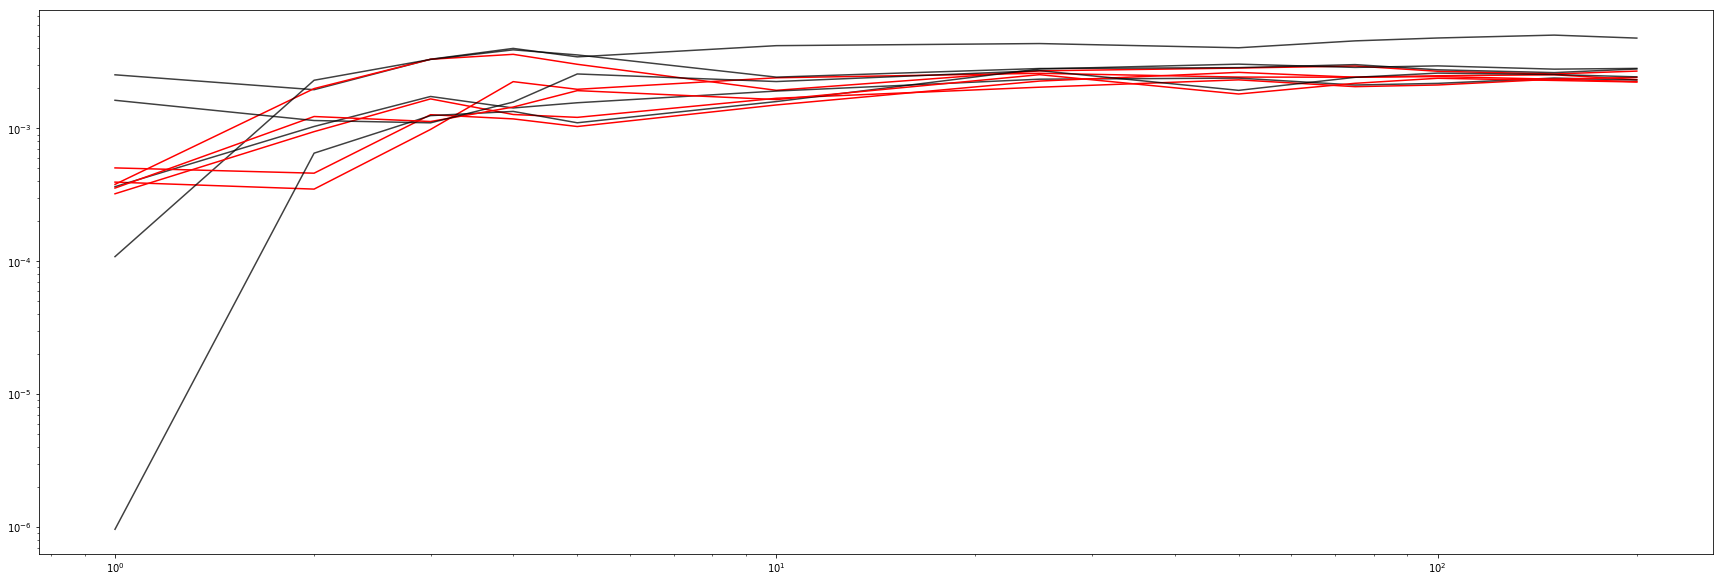

In [42]:
plt.figure(figsize=(30,10))
seed_list = np.random.randint(2,1E4,num_repeats)
for seed in seed_list:
    map_error = []
    map_error_analytical = []
    mud_error = []
#     for N in N_list:
    for M in M_list:
        D = compare(num_samples=N, 
            skew=1.5, 
            prior_x=-0.5, 
            prior_y=-0.5, 
            prior_std = prior_std, 
            data_std = data_std, 
            trials=M, 
            color_map = 'jet', 
            num_levels = 10, 
            seed=seed, 
            show_accept=False, 
            avg_contours=False, 
            show_plot=False)
#         map_error.append(D['map_pred_error'])
        map_error_analytical.append(D['map_pred_error'])
        mud_error.append(D['mud_pred_error_s'])
#     plt.plot(M_list, map_error, label='Bayesian', c='b', alpha=1)
    plt.plot(M_list, map_error_analytical, label='Deterministic', c='r', alpha=1)
    plt.plot(M_list, mud_error, label='Consistent Scalar', c='k', alpha=0.75)
plt.xscale('log')
plt.yscale('log')
# plt.ylim([1E-1, 10])
# plt.legend()
plt.xlabel('M')
plt.ylabel('Mean Squared Prediction Error')
for ftype in ['png', 'svg', 'pdf']:
    plt.savefig('error_M_N%d_p%1.3e_d%1.3e_t%d.%s'%(N,prior_std,data_std,num_repeats,ftype))
plt.show()

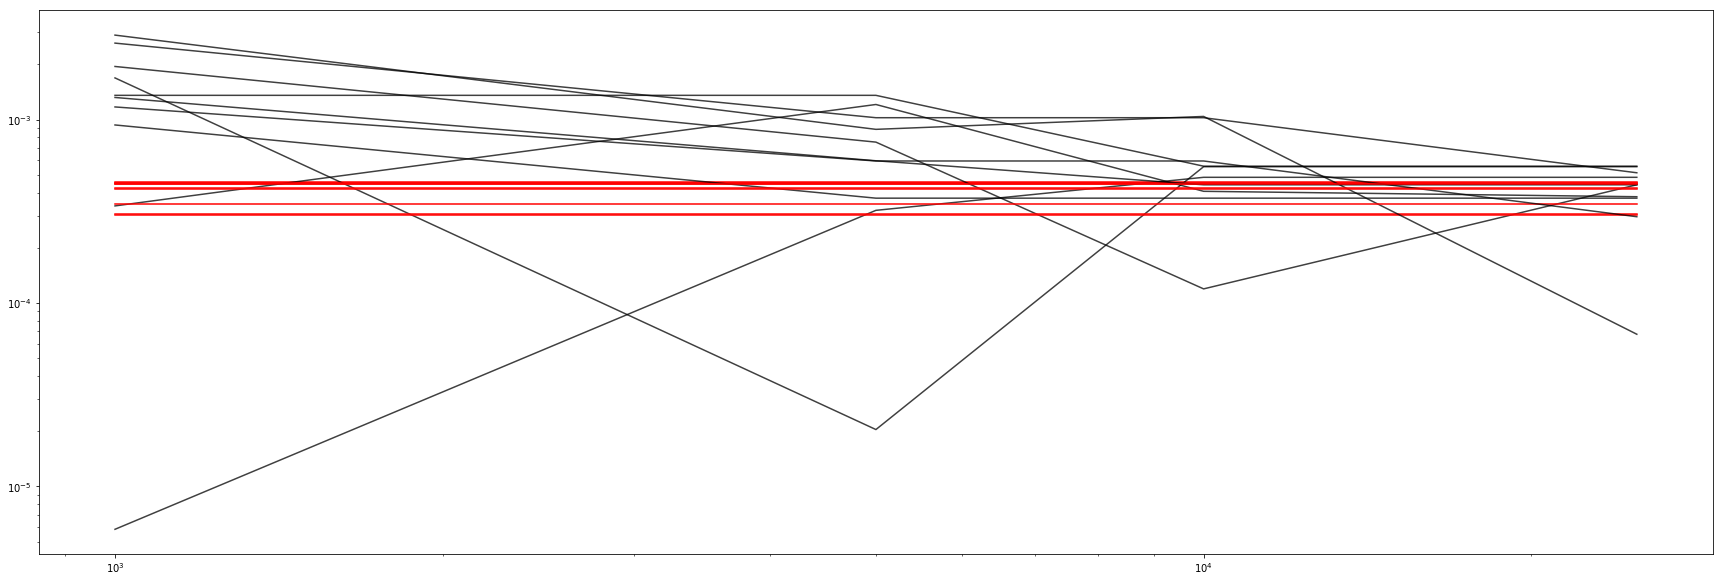

In [47]:
num_repeats = 10
N_list = [1000, 5000, 10000, 25000]
M_list = [1,2,3,4,5] + [10,25,50] + [75,100,150,200] # + [300,400,500]
# M_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
N = 2500
M = 1
data_std = 0.05
prior_std = 0.25

plt.figure(figsize=(30,10))
seed_list = np.random.randint(2,1E4,num_repeats)
for seed in seed_list:
    map_error = []
    map_error_analytical = []
    mud_error = []
    for N in N_list:
#     for M in M_list:
        D = compare(num_samples=N, 
            skew=1.5, 
            prior_x=-0.5, 
            prior_y=-0.5, 
            prior_std = prior_std, 
            data_std = data_std, 
            trials=M, 
            color_map = 'jet', 
            num_levels = 10, 
            seed=seed, 
            show_accept=False, 
            avg_contours=False, 
            show_plot=False)
#         map_error.append(D['map_pred_error'])
        map_error_analytical.append(D['map_pred_error'])
        mud_error.append(D['mud_pred_error_s'])
#     plt.plot(N_list, map_error, label='Bayesian', c='b', alpha=1)
    plt.plot(N_list, map_error_analytical, label='Deterministic', c='r', alpha=1)
    plt.plot(N_list, mud_error, label='Consistent Scalar', c='k', alpha=0.75)
plt.xscale('log')
plt.yscale('log')
# plt.ylim([1E-1, 10])
# plt.legend()
plt.xlabel('N')
plt.ylabel('Mean Squared Prediction Error')
for ftype in ['png', 'svg', 'pdf']:
    plt.savefig('error_N_M%d_p%1.3e_d%1.3e_t%d.%s'%(M,prior_std,data_std,num_repeats,ftype))

plt.show()

In [ ]:
num_repeats = 5
N_list = [1000, 10000, 25000]
M_list = [1,2,3,4,5] + [10,25,50] + [75,100,150,200] # + [300,400,500]
# M_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
N = 2500
M = 10
data_std = 0.05
prior_std = 0.25

plt.figure(figsize=(30,10))
seed_list = np.random.randint(2,1E4,num_repeats)
for seed in seed_list:
    map_error = []
    map_error_analytical = []
    mud_error = []
    for N in N_list:
#     for M in M_list:
        D = compare(num_samples=N, 
            skew=1.5, 
            prior_x=-0.5, 
            prior_y=-0.5, 
            prior_std = prior_std, 
            data_std = data_std, 
            trials=M, 
            color_map = 'jet', 
            num_levels = 10, 
            seed=seed, 
            show_accept=False, 
            avg_contours=False, 
            show_plot=False)
#         map_error.append(D['map_pred_error'])
        map_error_analytical.append(D['map_pred_error'])
        mud_error.append(D['mud_pred_error_s'])
#     plt.plot(N_list, map_error, label='Bayesian', c='b', alpha=1)
    plt.plot(N_list, map_error_analytical, label='Deterministic', c='r', alpha=1)
    plt.plot(N_list, mud_error, label='Consistent Scalar', c='k', alpha=0.75)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('Mean Squared Prediction Error')
# plt.ylim([1E-1, 10])
# plt.legend()
for ftype in ['png', 'svg', 'pdf']:
    plt.savefig('error_N_M%d_p%1.3e_d%1.3e_t%d.%s'%(M,prior_std,data_std,num_repeats,ftype))
plt.show()